In [1]:
import os

import torch
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt

from src.models import mae_vit_regressor
from src.datas import transforms

In [7]:
target_task = "TOC"
datapath = f"data/finetune/{target_task}%/train/"
datapoint = "1.csv"
spe_path = os.path.join(datapath, 'spe', datapoint)
target_path = os.path.join(datapath, 'target', datapoint)

spe = torch.from_numpy(np.loadtxt(
    spe_path, delimiter=",", dtype=float)
).float().unsqueeze(0)

target = torch.from_numpy(
    np.loadtxt(target_path, delimiter=",", dtype=float)
).unsqueeze(0)

spe_transfrom = transforms.InstanceNorm()
target_mean = torch.load(f"src/datas/xpt_{target_task}_target_mean.pth")
target_std = torch.load(f"src/datas/xpt_{target_task}_target_std.pth")
target_transform = transforms.Normalize(target_mean, target_std)

spe_tfm = spe_transfrom(spe)
target_tfm = target_transform(target)

In [8]:
print(target_tfm)

tensor([-0.1571], dtype=torch.float64)


In [9]:
pretrained_weight = f"results/pretrain-mask-ratio-0.7-blr-1e-4-transform-instance_normalize/{target_task}/model.ckpt"
model = mae_vit_regressor.mae_vit_base_patch16(
    pretrained=True,
    weights=pretrained_weight,
)
model = model.eval()

In [10]:
with torch.no_grad():
    outputs = model(spe_tfm)
print(outputs.squeeze())

tensor(-0.1173)


torch.Size([1, 129, 768]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 129])


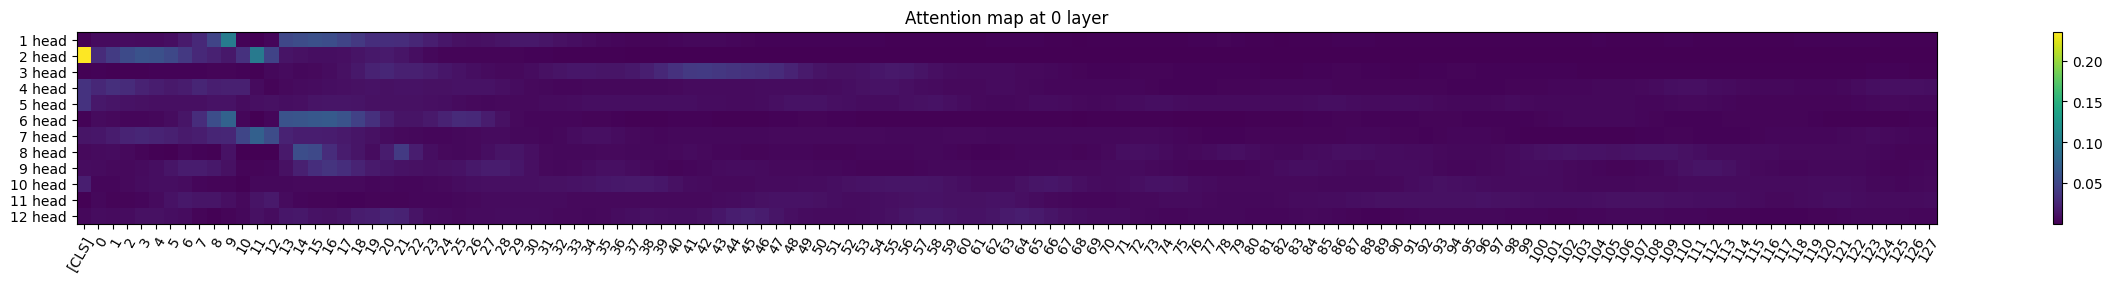

torch.Size([1, 129, 768]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 129])


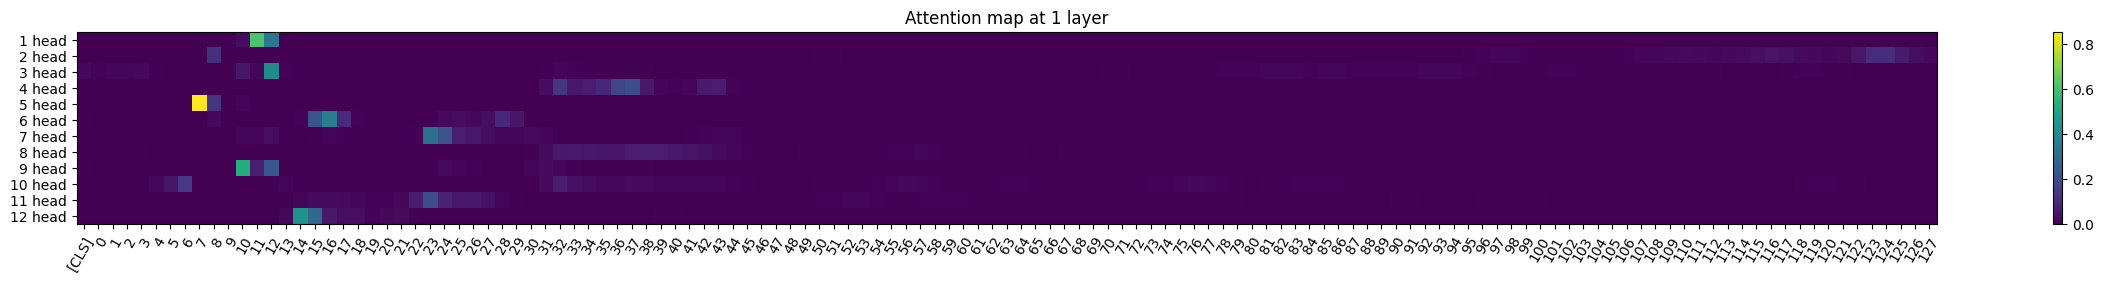

torch.Size([1, 129, 768]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 129])


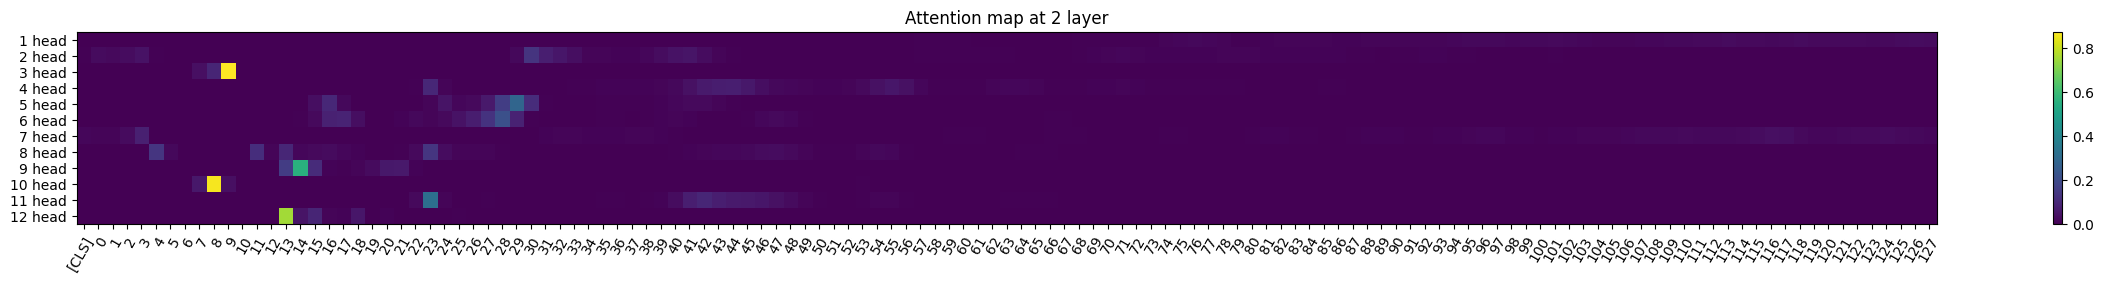

torch.Size([1, 129, 768]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 129])


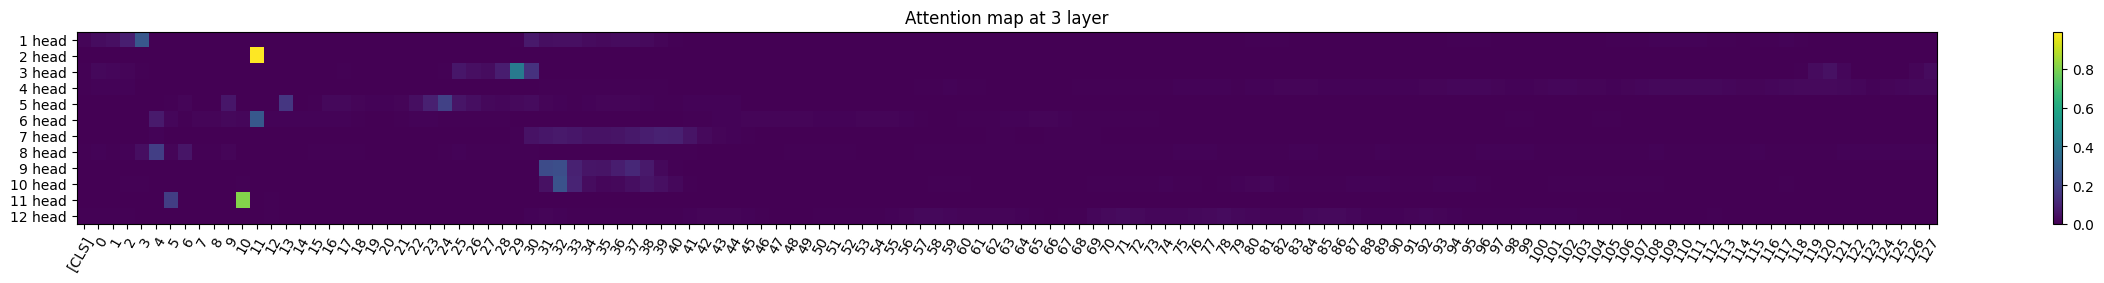

torch.Size([1, 129, 768]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 129])


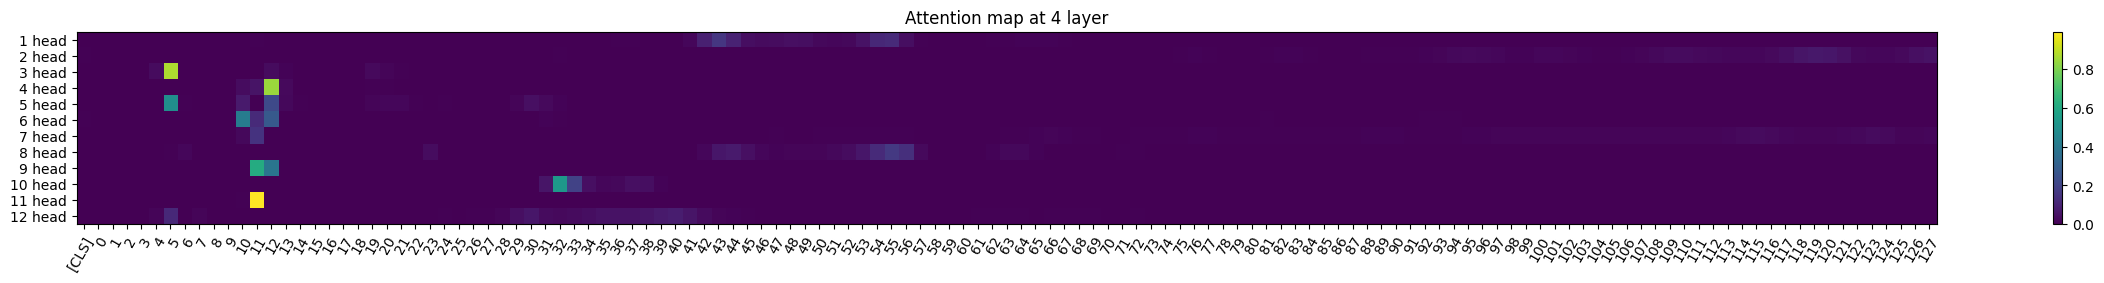

torch.Size([1, 129, 768]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 129])


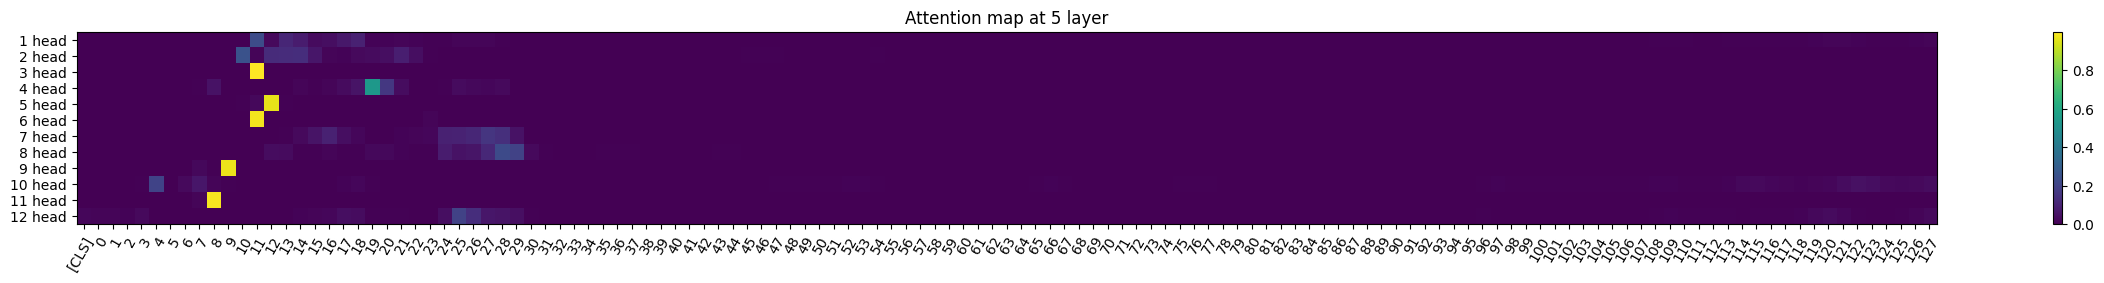

torch.Size([1, 129, 768]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 129])


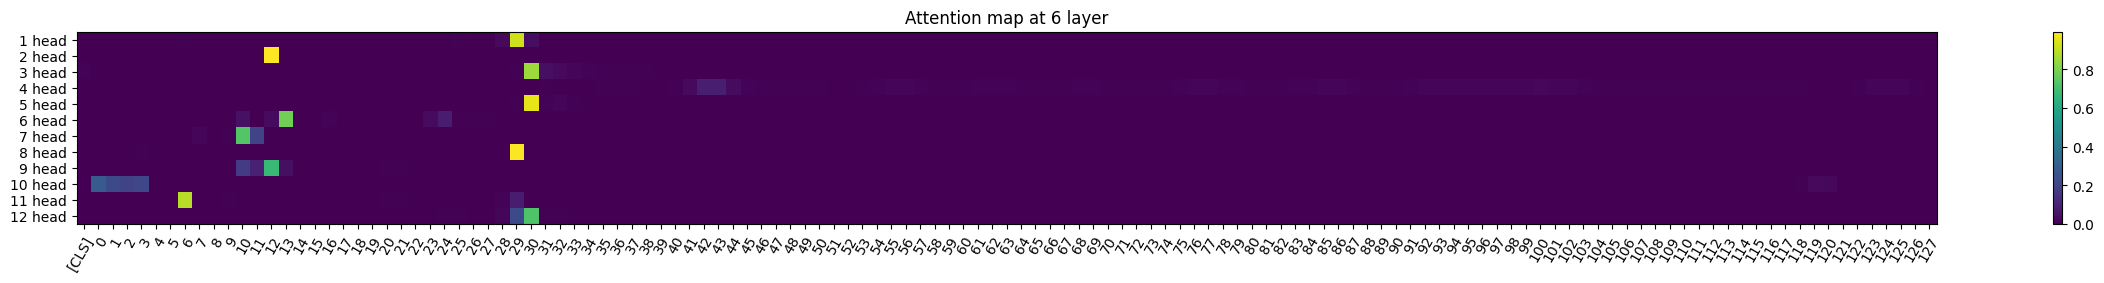

torch.Size([1, 129, 768]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 129])


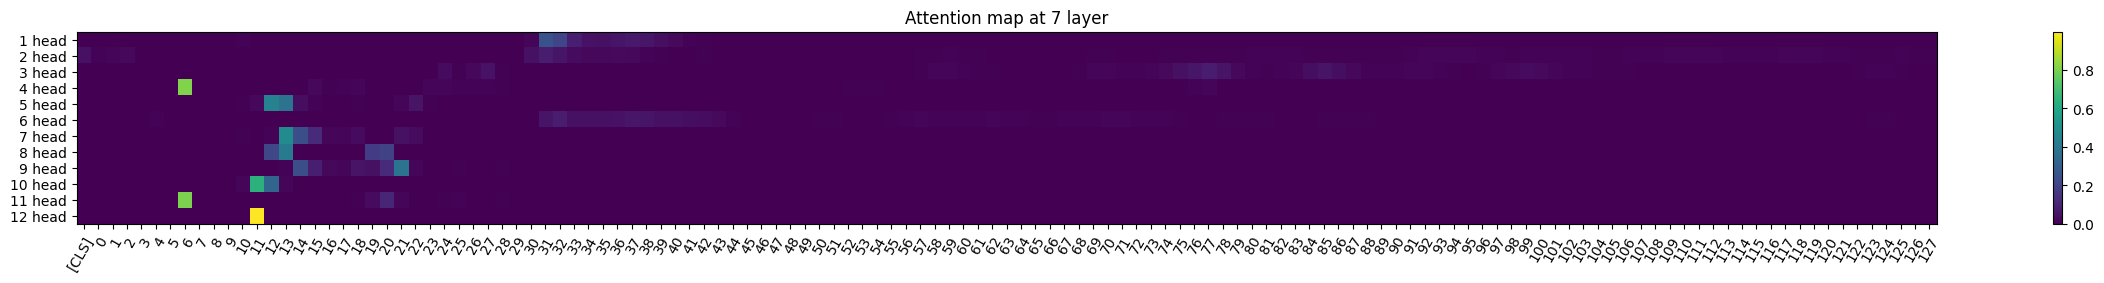

torch.Size([1, 129, 768]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 129])


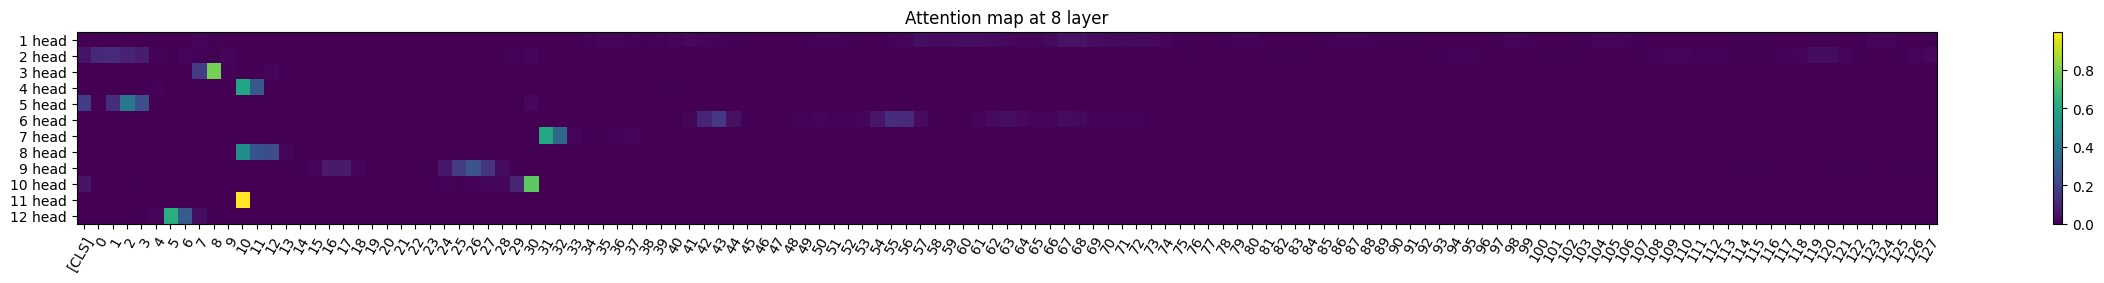

torch.Size([1, 129, 768]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 129])


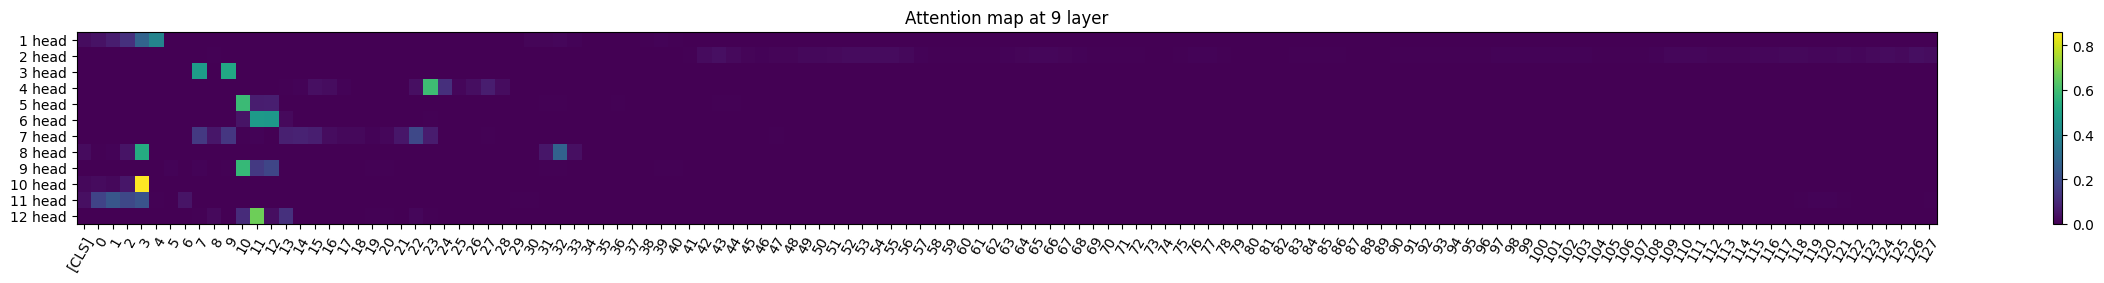

torch.Size([1, 129, 768]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 129])


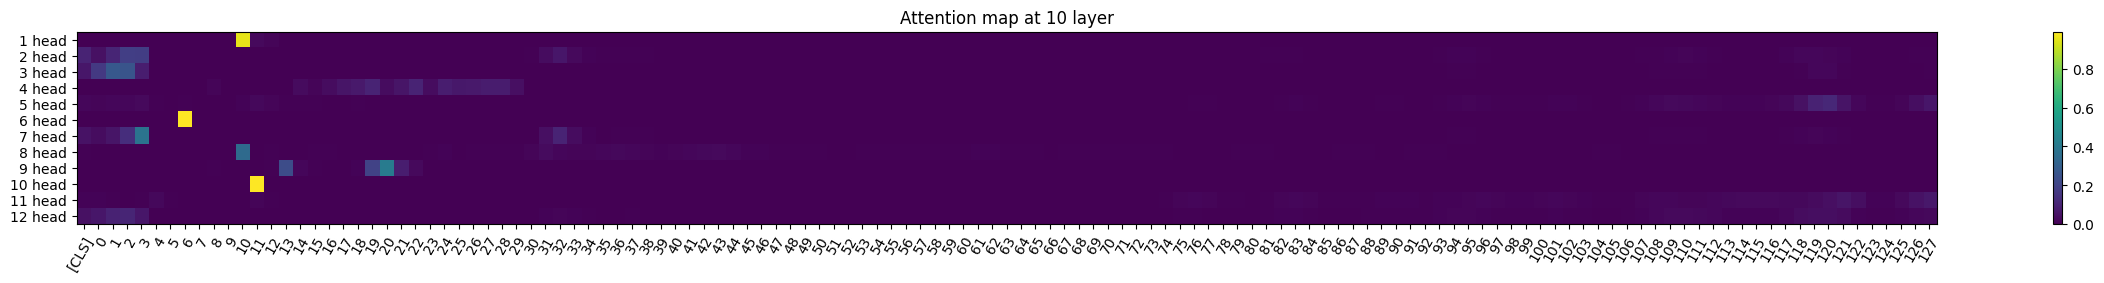

torch.Size([1, 129, 768]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 64]) torch.Size([1, 12, 129, 129])


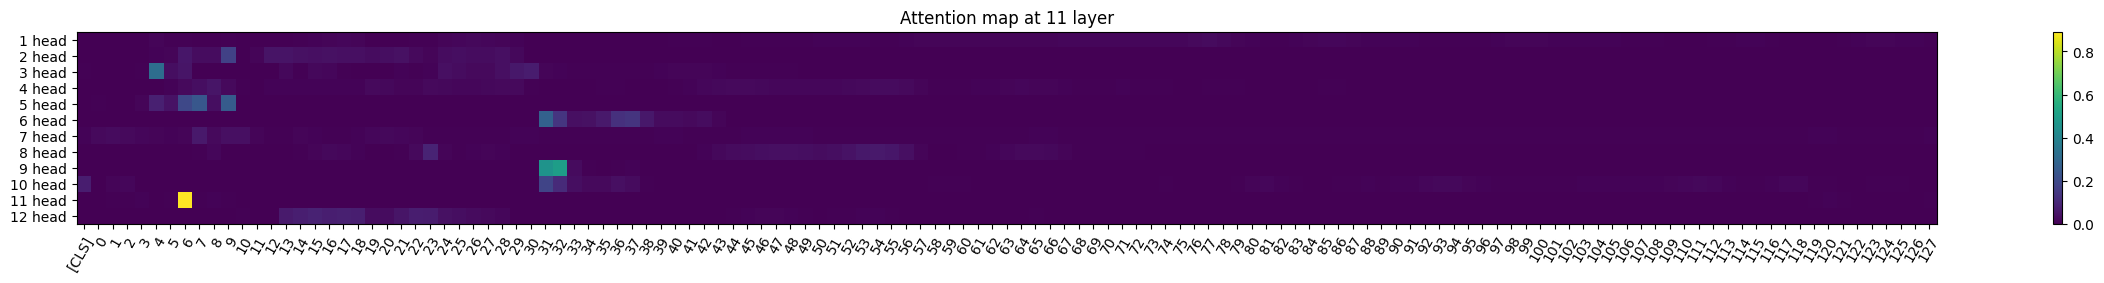

tensor(-0.1173)


In [11]:
x = spe_tfm.clone()
with torch.no_grad():
    x = model.patch_embed(x)

    # add pos embed w/o cls token
    x = x + model.pos_embed[:, 1:, :]

    # append cls token
    cls_token = model.cls_token + model.pos_embed[:, :1, :]
    cls_tokens = cls_token.expand(x.shape[0], -1, -1)
    x = torch.cat((cls_tokens, x), dim=1)

    # apply Transformer blocks
    for layer, blk in enumerate(model.blocks):
        x_norm = blk.norm1(x)

        # Attention
        B, N, C = x_norm.shape
        qkv = blk.attn.qkv(x_norm).reshape(
            B, N, 3, blk.attn.num_heads, blk.attn.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        q, k = blk.attn.q_norm(q), blk.attn.k_norm(k)

        q = q * blk.attn.scale
        attn = q @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        attn = blk.attn.attn_drop(attn)
        print(x_norm.shape, q.shape, k.shape, v.shape, attn.shape)


        fig, ax = plt.subplots(figsize=(30, 2.5))

        cax = ax.imshow(attn[0, :, 0, :], aspect='auto', cmap='viridis')

        ax.set_xticks(
            np.arange(attn.shape[-1]),
            labels=["[CLS]"] +
            [f"{i}" for i in range(attn.shape[-1] - 1)]
        )
        plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
                    rotation_mode="anchor")

        ax.set_yticks(
            np.arange(attn.shape[1]),
            [f"{i + 1} head" for i in range(attn.shape[1])]
        )
        ax.set_title(f"Attention map at {layer} layer")

        cbar = fig.colorbar(cax, ax=ax, orientation='vertical')

        plt.show()
        
        x_attn = attn @ v

        x_attn = x_attn.transpose(1, 2).reshape(B, N, C)
        x_attn = blk.attn.proj(x_attn)
        x_attn = blk.attn.proj_drop(x_attn)

        x = x + blk.drop_path1(blk.ls1(x_attn))
        x = x + blk.drop_path2(blk.ls2(blk.mlp(blk.norm2(x))))
    x = model.norm(x)

    # transform the cls to logits
    # (N, 1, 2)
    pred = (
        model.fc(x[:, 0])
    )  # scale to 0-100, relevent to weighting percent unit

print(pred.squeeze())